# SB2 — RSM variants on a shared DOE (imports SB1 visuals)

This notebook **imports** the plotting utilities from `evaluator.py` exactly like SB1 and uses them to render plots.
It assumes `results/<timestamp>_TB_RSM_B50-final/all_runs.csv` exists and already includes RSM2/RSM3 rows.

In [1]:
import os, sys, time, json, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image, Markdown, HTML

# Ensure local modules are importable (same as SB1)
ROOT = Path("/mnt/data").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import main  # uses /mnt/data/main.py
from evaluator import (
    load_logs, aggregate_regret, plot_regret_curves, add_normalized_regret,
    aggregate_regret_norm, plot_regret_norm_curves, plot_box_regret_at_T,
    plot_box_regret_norm_at_T, plot_box_best_value_at_T, plot_ybest_curves,
    rank_by_group, winrate_by_group, plot_rank_heatmap, plot_winrate_heatmap,
    save_rank_tables, save_tables, export_best_at_T_table,
    save_best_at_T_tables_as_png, render_boxplot_side_tables
)  # uses /mnt/data/evaluator.py

def find_latest_results(exp_name: str) -> Path:
    root = Path("results")
    if not root.exists():
        raise FileNotFoundError("No results/ folder yet.")
    cands = [p for p in root.glob(f"*_{exp_name}") if p.is_dir()]
    if not cands:
        # fallback: any folder containing exp_name
        cands = [p for p in root.glob("*_*") if exp_name in p.name]
    if not cands:
        raise FileNotFoundError(f"No results subfolder matching: {exp_name}")
    return max(cands, key=lambda p: p.stat().st_mtime)

def show_pngs(paths, width=820):
    for p in paths:
        p = Path(p)
        if p.exists():
            display(Image(filename=str(p), width=width))

def show_all_core_plots(outdir: Path):
    # Mirrors SB1 grouping
    plots = outdir / "plots"
    groups = [
        "regret_curves", "regret_norm_curves",
        "regret", "regret_norm", "best_value", "heatmaps"
    ]
    all_imgs = []
    for g in groups:
        d = plots / g
        if d.exists():
            all_imgs += sorted(d.glob("*.png"))
    if all_imgs:
        print(f"Showing {len(all_imgs)} plot images ...")
        show_pngs(all_imgs)

    table_pngs = sorted((outdir/"plots").rglob("*_table.png"))
    if table_pngs:
        print(f"Showing {len(table_pngs)} boxplot side-table PNGs ...")
        show_pngs(table_pngs, width=640)

    global_tables = sorted((outdir/"tables").glob("best_at_T_*.png"))
    if global_tables:
        print("Global Best@T tables:")
        show_pngs(global_tables, width=720)


## Load results and generate plots with imported evaluator

Using results dir: results\20251026_123456_TB_RSM_B50-final
all_runs.csv shape: (16000, 21)
[warn] render_boxplot_side_tables: name '_df_apply_elementwise' is not defined
Showing 10 plot images ...


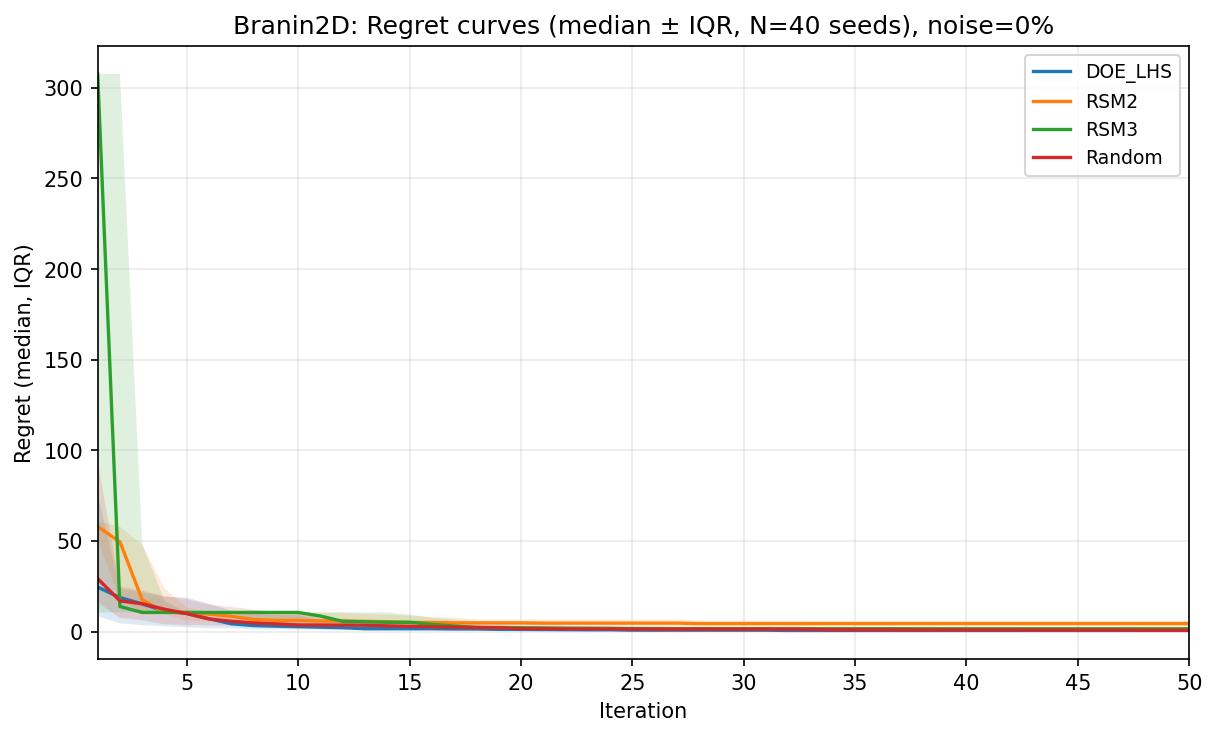

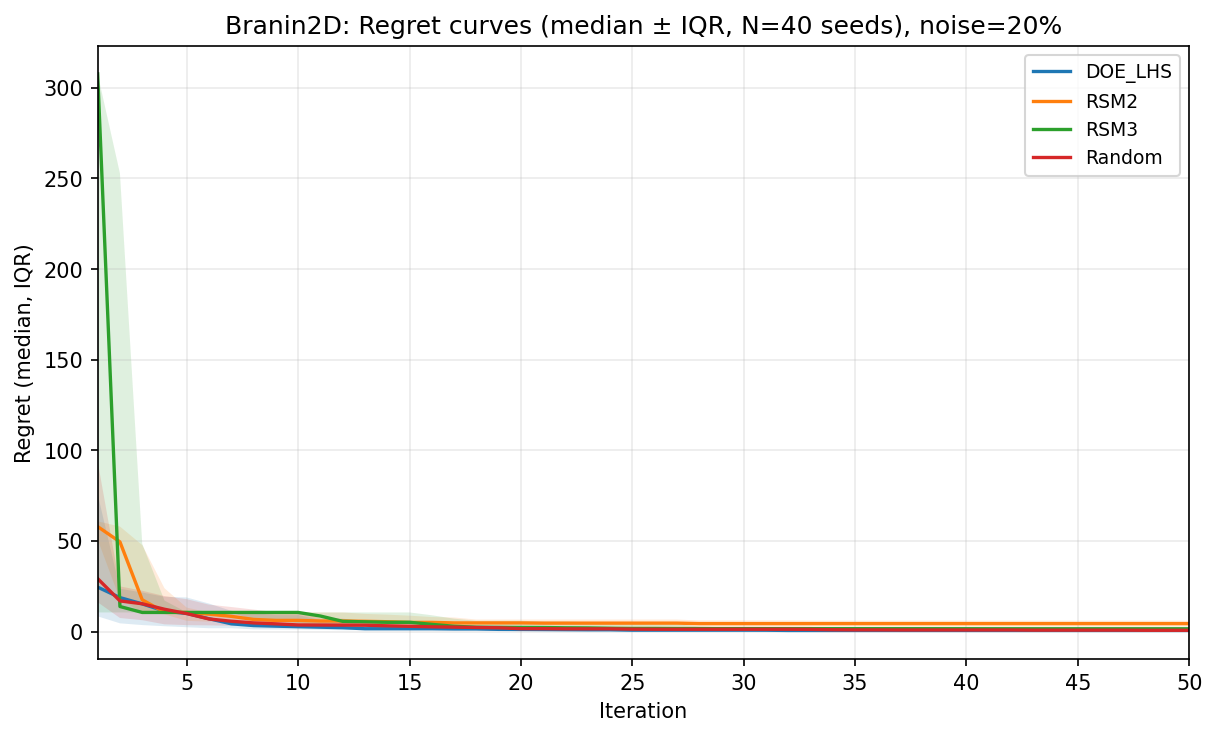

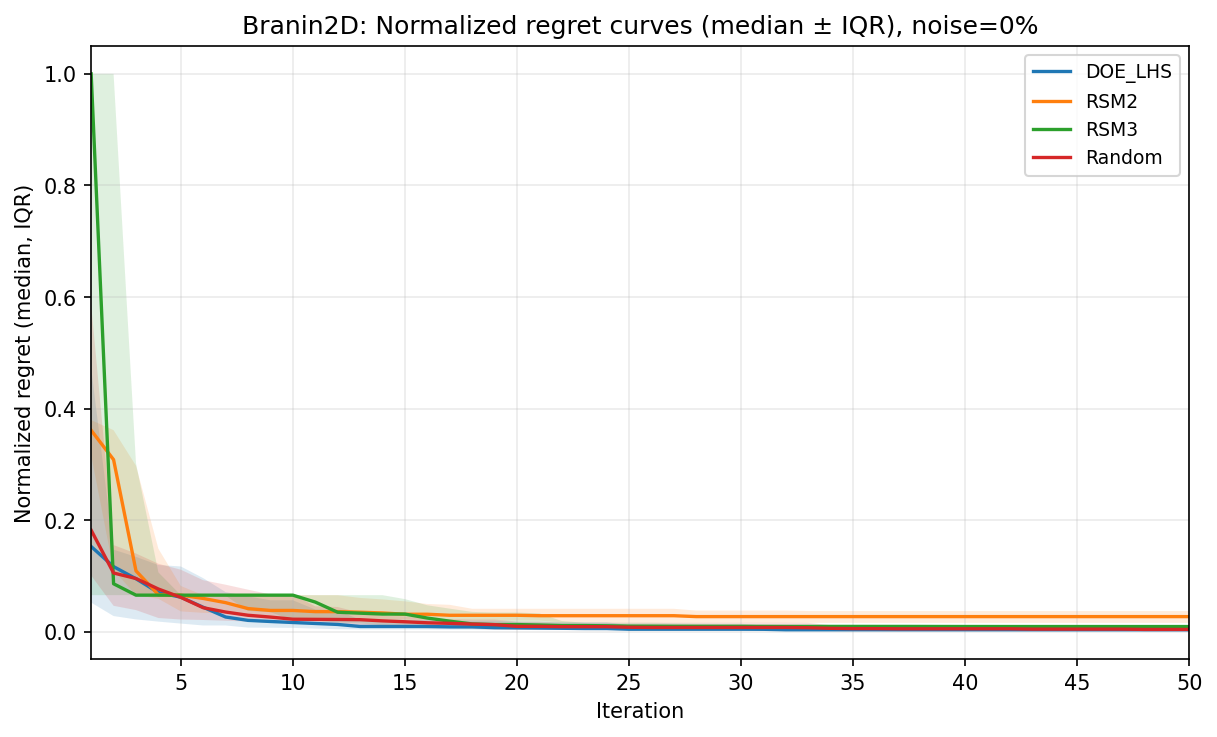

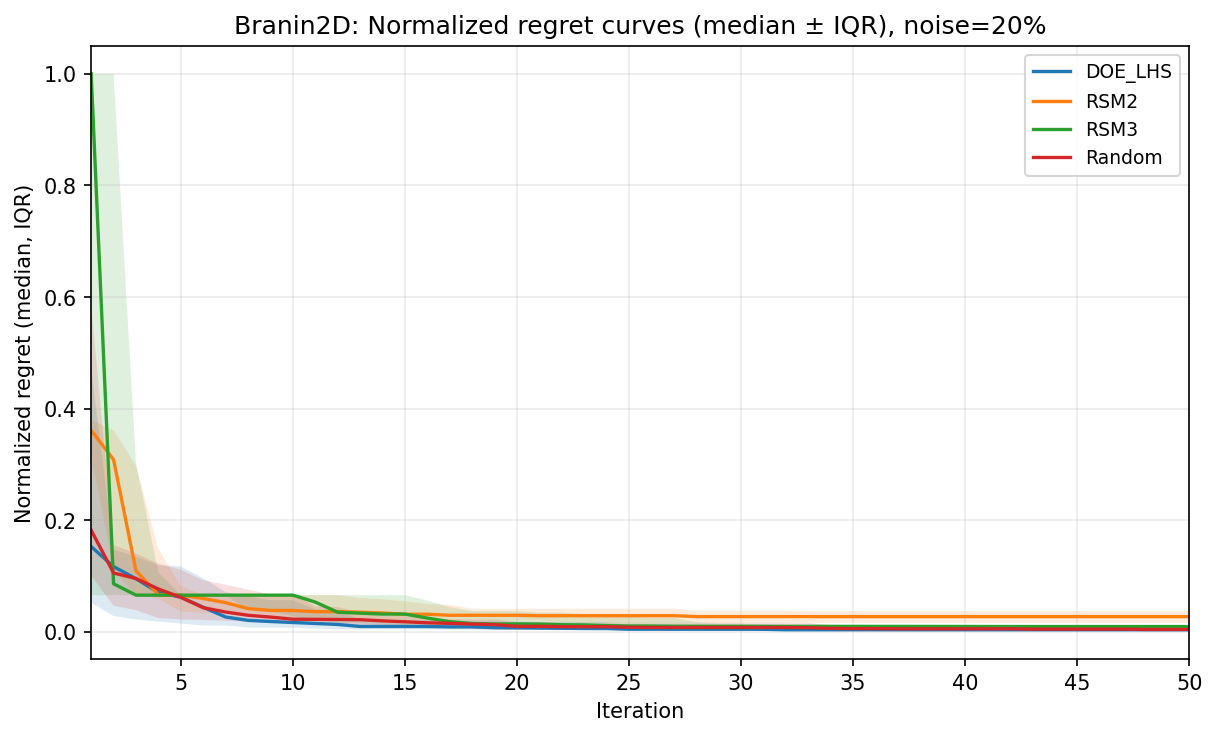

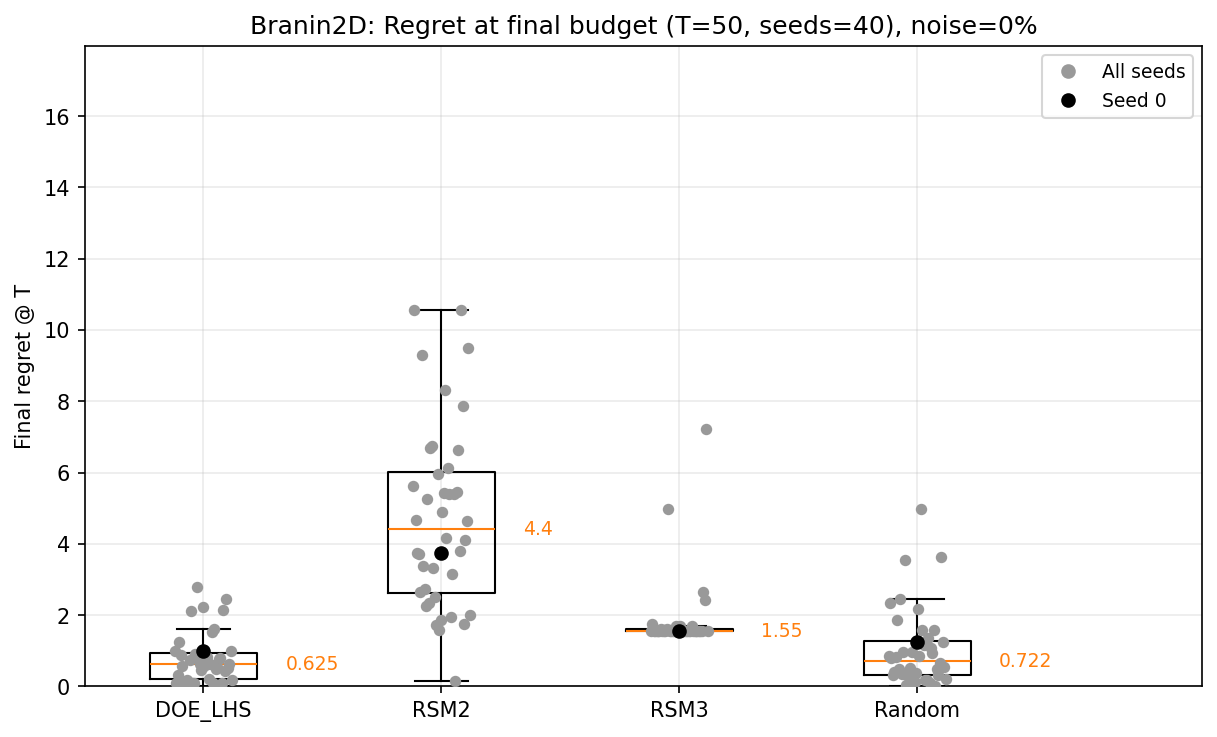

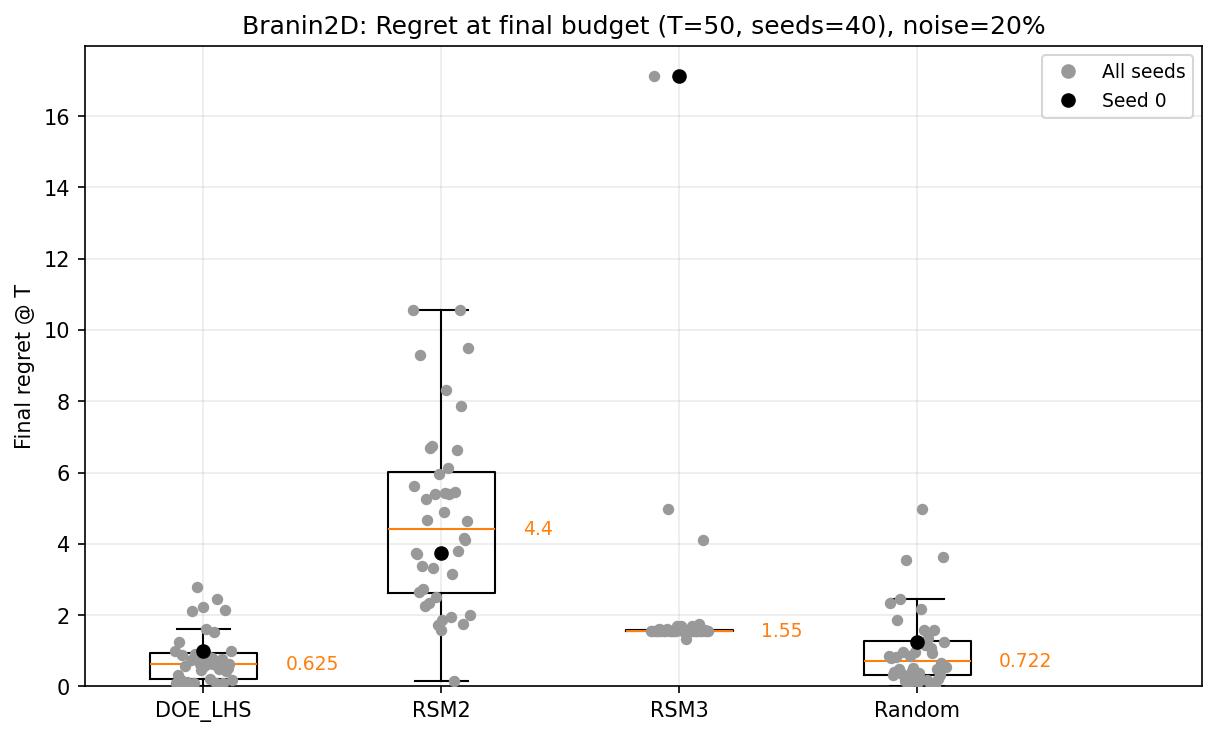

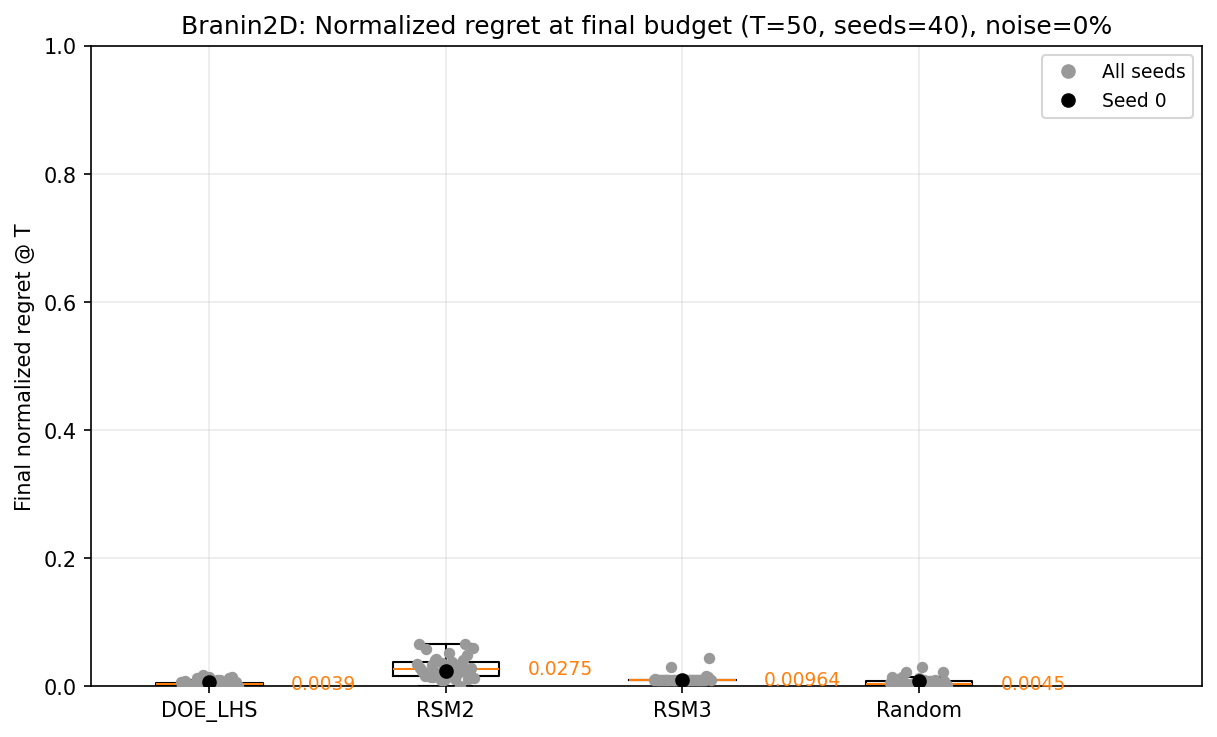

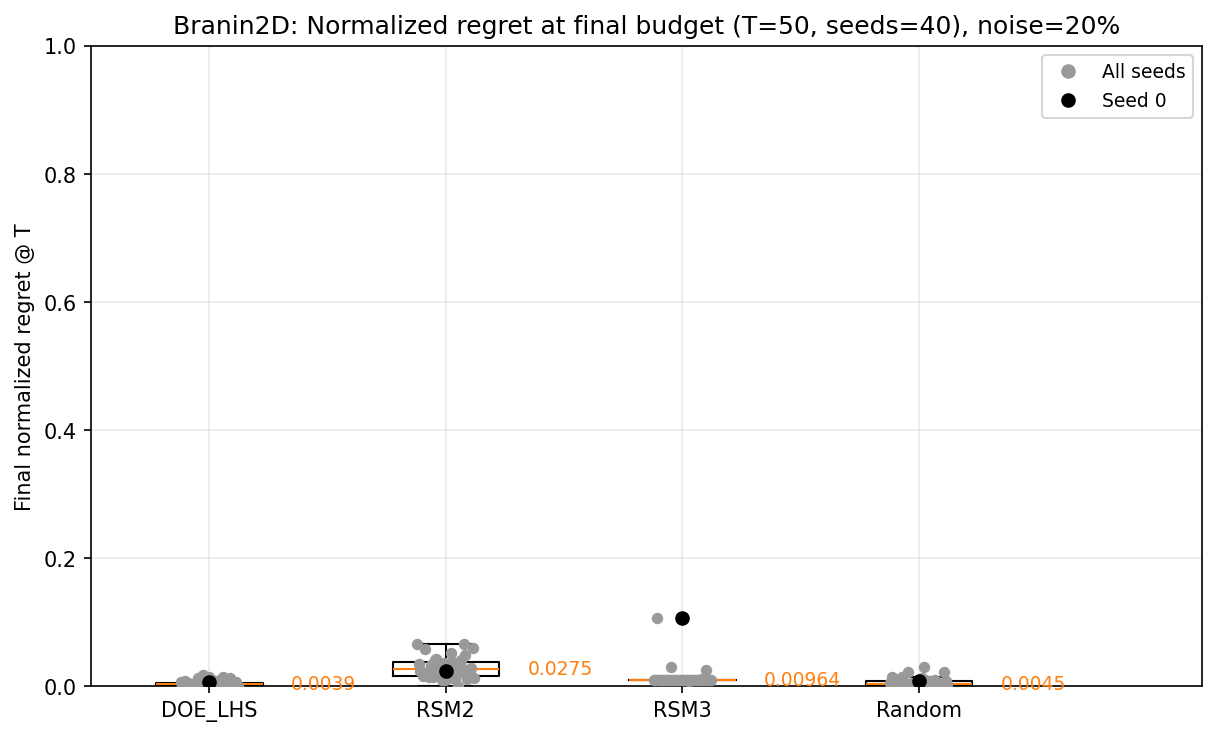

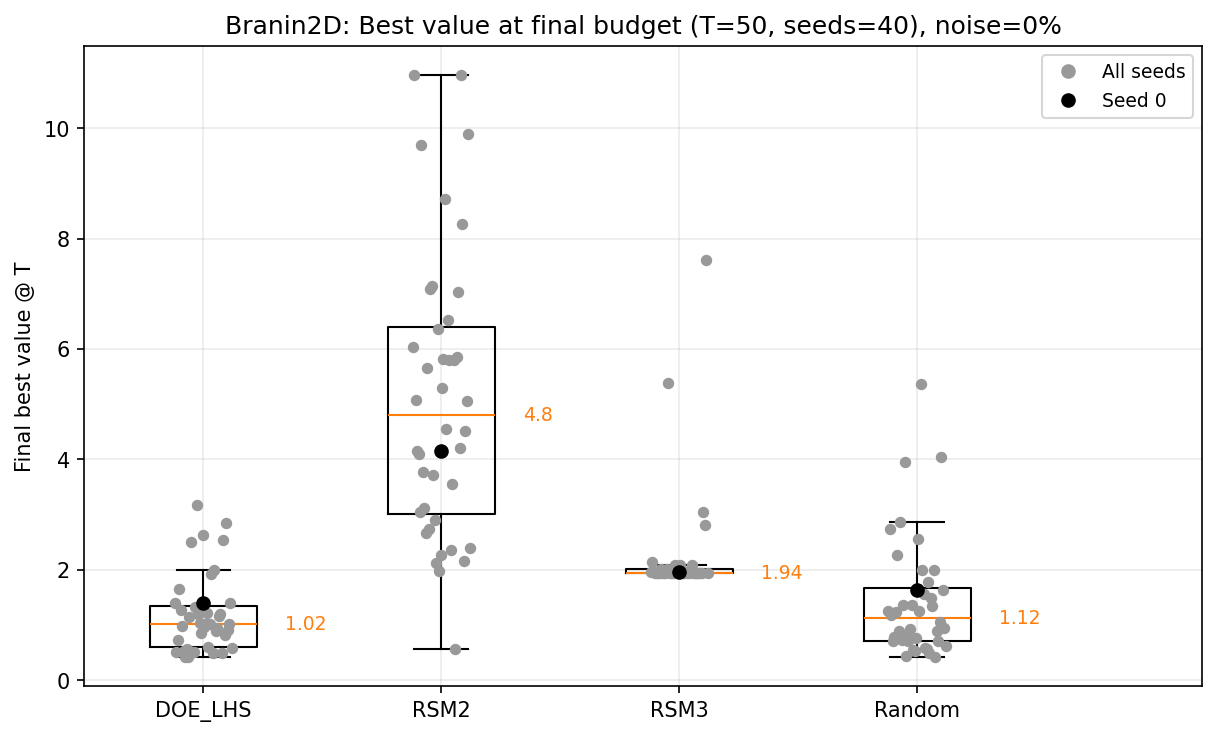

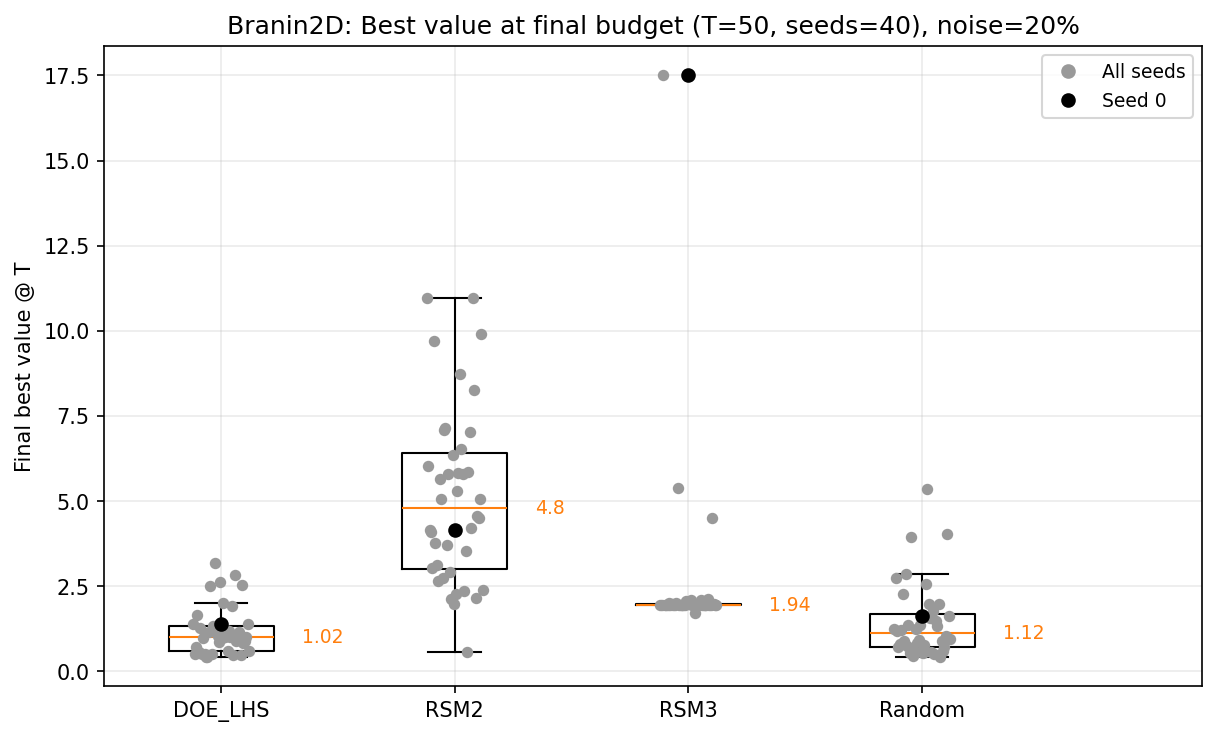

In [2]:
# Use your SB2 exp
main.EXP_NAME = "TB_RSM_B50-final"
outdir = find_latest_results(main.EXP_NAME)
print("Using results dir:", outdir)

# unified logs
df_all = load_logs(outdir)
print("all_runs.csv shape:", df_all.shape)
methods = ["DOE_LHS", "RSM2", "RSM3", "Random"]

# --- Boxplots at T (true regret) ---
plot_box_regret_at_T(df_all, outdir, method_order=methods, metric="regret")

# --- Regret curves (median ± IQR, true) ---
agg_true = aggregate_regret(df_all, use_observed=False)
plot_regret_curves(agg_true, outdir, method_order=methods)

# --- Normalized regret (optional, if present) ---
dfn = add_normalized_regret(df_all.copy())
if "regret_norm" in dfn.columns:
    aggn = aggregate_regret_norm(dfn)
    plot_regret_norm_curves(aggn, outdir, method_order=methods)
    plot_box_regret_norm_at_T(dfn, outdir, method_order=methods)

# --- Best value @T (true) ---
plot_box_best_value_at_T(df_all, outdir, method_order=methods)

# --- Tables (side-tables + best@T PNGs) ---
try:
    save_best_at_T_tables_as_png(outdir, decimals=3)
except Exception as e:
    print("[warn] save_best_at_T_tables_as_png:", e)
try:
    render_boxplot_side_tables(outdir, decimals=3)
except Exception as e:
    print("[warn] render_boxplot_side_tables:", e)

# Display all generated images in the same way SB1 does
show_all_core_plots(outdir)


### Last 10 iterations

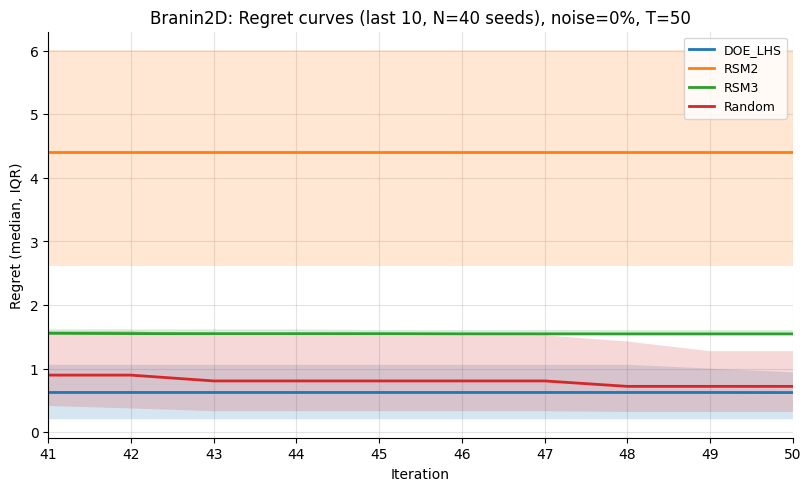

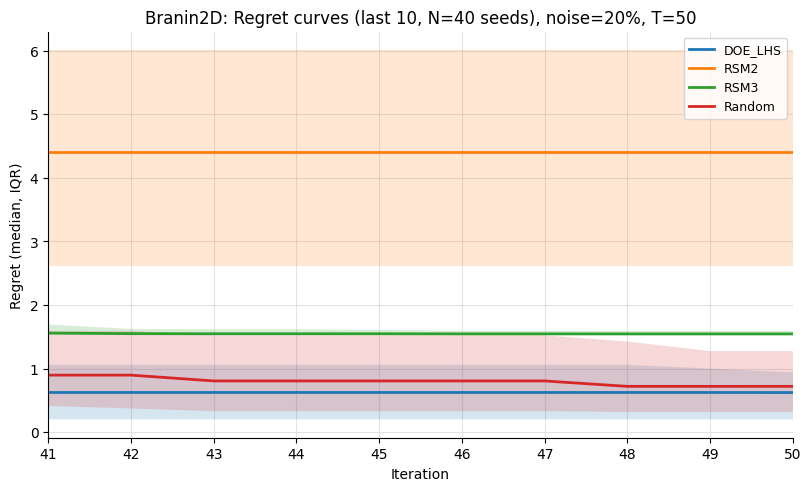

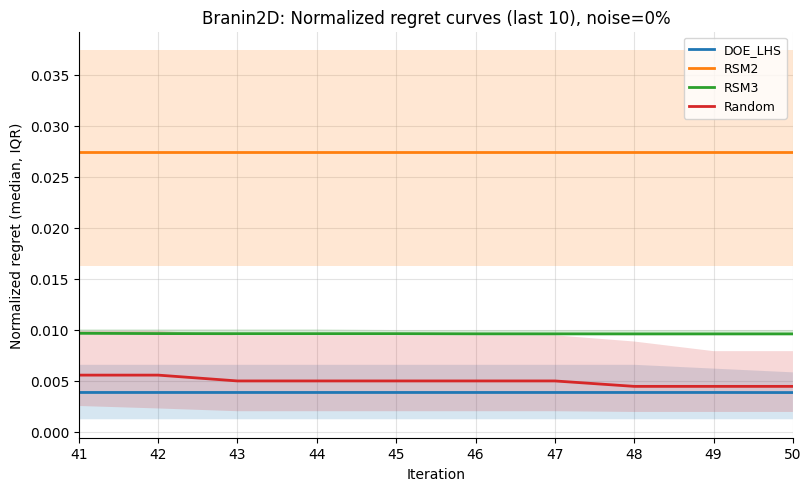

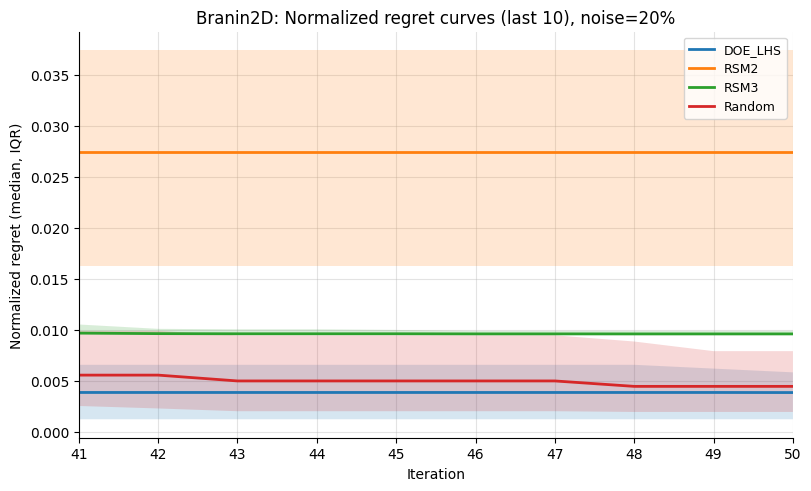

In [10]:
# --- NEU: x-Achse bis T=max (z.B. 50), unabhängig vom last-10 Slice ---

# volle Aggregate (für T-Bestimmung)
agg_true_full = aggregate_regret(df_all, use_observed=False)
aggn_full     = aggregate_regret_norm(dfn)

# gewünschte Reihenfolge für alle Plots:
methods = ["DOE_LHS", "RSM2", "RSM3", "Random"]

# last-10 pro Methode (zum Plotten)
def _last_k_by_method(agg: pd.DataFrame, k: int) -> pd.DataFrame:
    cols = agg.columns.tolist()
    has_budget = "budget" in agg.columns
    pieces = []
    for p in sorted(agg["problem"].unique()):
        ap = agg[agg["problem"] == p]
        budgets = sorted(ap["budget"].unique()) if has_budget else [None]
        for b in budgets:
            ab = ap if b is None else ap[ap["budget"] == b]
            for n in sorted(ab["noise_pct"].unique()):
                sub = ab[ab["noise_pct"] == n]
                if sub.empty:
                    continue
                present = [m for m in methods if m in set(sub["method"])]
                for m in present:
                    sm = sub[sub["method"] == m].sort_values("iter")
                    iters = sorted(sm["iter"].unique())
                    take = iters[-min(k, len(iters)):]
                    pieces.append(sm[sm["iter"].isin(take)])
    return pd.concat(pieces, ignore_index=True)[cols]

agg_true_l10 = _last_k_by_method(agg_true_full, k=10)
aggn_l10     = _last_k_by_method(aggn_full,     k=10)

# T=max je (problem, noise[, budget]) aus den vollen Aggregaten bestimmen
def _Tinfo_from_full(agg_full: pd.DataFrame):
    info = {}
    has_budget = "budget" in agg_full.columns
    for p in agg_full["problem"].unique():
        ap = agg_full[agg_full["problem"] == p]
        budgets = sorted(ap["budget"].unique()) if has_budget else [None]
        for b in budgets:
            ab = ap if b is None else ap[ap["budget"] == b]
            for n in sorted(ab["noise_pct"].unique()):
                sub = ab[ab["noise_pct"] == n]
                if sub.empty:
                    continue
                it_min = int(sub["iter"].min())
                it_max = int(sub["iter"].max())
                x_off  = 1 if it_min == 0 else 0     # 0-based → +1
                T_end  = it_max + x_off               # z.B. 49+1 = 50
                info[(p, n, b)] = (T_end, x_off)
    return info

Tinfo_true = _Tinfo_from_full(agg_true_full)
Tinfo_norm = _Tinfo_from_full(aggn_full)

def _plot_windowed_curves(slice_lastk: pd.DataFrame, Tinfo_full: dict,
                          title_prefix: str, ylabel: str, k:int=10):
    has_budget = "budget" in slice_lastk.columns
    for p in sorted(slice_lastk["problem"].unique()):
        ap = slice_lastk[slice_lastk["problem"] == p]
        budgets = sorted(ap["budget"].unique()) if has_budget else [None]
        for b in budgets:
            ab = ap if b is None else ap[ap["budget"] == b]
            for n in sorted(ab["noise_pct"].unique()):
                key = (p, n, b)
                if key not in Tinfo_full:
                    continue
                T_end, x_off = Tinfo_full[key]
                xmin, xmax = max(1, T_end - (k - 1)), T_end
                sub = ab[ab["noise_pct"] == n]
                if sub.empty:
                    continue
                present = [m for m in methods if m in set(sub["method"])]

                fig, ax = plt.subplots(figsize=(8, 4.8))
                for m in present:
                    sm = sub[sub["method"] == m].sort_values("iter")
                    x  = sm["iter"].to_numpy(dtype=float) + x_off
                    y  = sm["median"].to_numpy(dtype=float)
                    q1 = sm["q25"].to_numpy(dtype=float)
                    q3 = sm["q75"].to_numpy(dtype=float)
                    ax.plot(x, y, label=m, linewidth=2.0)
                    ax.fill_between(x, q1, q3, alpha=0.18)

                seeds_txt = ""
                if "n" in sub.columns and sub["n"].notna().any():
                    try: seeds_txt = f", N={int(sub['n'].max())} seeds"
                    except: pass

                title = f"{p}: {title_prefix} (last {k}{seeds_txt}), noise={int(round(100*float(n)))}%"
                if b is not None:
                    title += f", T={int(b)}"

                ax.set_title(title)
                ax.set_xlabel("Iteration")
                ax.set_ylabel(ylabel)
                ax.set_xlim(xmin, xmax)                # endet garantiert bei T=max
                xt = list(range(xmin, xmax+1))
                if len(xt) > 10:
                    step = int(np.ceil(len(xt)/10))
                    xt = list(range(xmin, xmax+1, step))
                    if xt[-1] != xmax: xt.append(xmax)
                ax.set_xticks(xt)
                ax.grid(True, alpha=0.35); ax.set_axisbelow(True)
                for s in ("top","right"): ax.spines[s].set_visible(False)
                ax.legend(loc="upper right")
                plt.show()

# Anzeigen: true & normalized – je Plot läuft die x-Achse bis T=max (z.B. 50)
_plot_windowed_curves(agg_true_l10, Tinfo_true, title_prefix="Regret curves",            ylabel="Regret (median, IQR)", k=10)
_plot_windowed_curves(aggn_l10,     Tinfo_norm, title_prefix="Normalized regret curves", ylabel="Normalized regret (median, IQR)", k=10)


### Overview Tables

In [5]:
# === AUC der normalized regret curves (full & last-10) ===
from pathlib import Path
import numpy as np
import pandas as pd

# Falls outdir noch nicht gesetzt wurde:
try:
    outdir
except NameError:
    def find_latest_results(exp_name: str) -> Path:
        root = Path("results")
        if not root.exists():
            raise FileNotFoundError("No results/ folder yet.")
        cands = [p for p in root.glob(f"*_{exp_name}") if p.is_dir()]
        if not cands:
            cands = [p for p in root.glob("*_*") if exp_name in p.name]
        if not cands:
            raise FileNotFoundError(f"No results subfolder matching: {exp_name}")
        return max(cands, key=lambda p: p.stat().st_mtime)
    outdir = find_latest_results(main.EXP_NAME)

tables_dir = Path(outdir) / "tables"
tables_dir.mkdir(parents=True, exist_ok=True)

# 1) Daten laden und normalized regret aggregieren (Median, IQR über Seeds)
df_all = load_logs(outdir)
dfn = add_normalized_regret(df_all.copy())
aggn = aggregate_regret_norm(dfn)  # columns: problem, method, iter, [budget], noise_pct, median, q25, q75, ...

# Helper: Aggregat auf die letzten k Iterationen kürzen (pro Problem/Noise/[Budget])
def _last_k_iters(agg: pd.DataFrame, k: int) -> pd.DataFrame:
    gcols = ["problem", "noise_pct"] + (["budget"] if "budget" in agg.columns else [])
    thr = agg.groupby(gcols)["iter"].max().reset_index().rename(columns={"iter": "iter_max"})
    m = agg.merge(thr, on=gcols, how="left")
    out = m[m["iter"] >= m["iter_max"] - (k - 1)].copy()
    return out[agg.columns]

# AUC-Berechnung (Trapezregel über 'median' vs. 'iter')
def _compute_auc_from_agg(agg: pd.DataFrame) -> pd.DataFrame:
    gcols = ["problem", "method", "noise_pct"] + (["budget"] if "budget" in agg.columns else [])
    rows = []
    for keys, g in agg.groupby(gcols, dropna=False):
        gs = g.sort_values("iter")
        x = gs["iter"].to_numpy(dtype=float)
        y = gs["median"].to_numpy(dtype=float)
        # Trapezregel (Schrittweite = 1 Iteration → vergleichbar bei fixem T)
        auc = float(np.trapz(y, x))
        rows.append(dict(zip(gcols, keys if isinstance(keys, tuple) else (keys,))))
        rows[-1]["T"]   = int(gs["iter"].max())      # letzte Iteration (≈ Budget)
        rows[-1]["AUC"] = auc
    df_auc = pd.DataFrame(rows)
    # schöne Sortierung
    sort_cols = [c for c in ["problem","noise_pct","budget","method"] if c in df_auc.columns]
    return df_auc.sort_values(sort_cols).reset_index(drop=True)

# 2) FULL: AUC über den gesamten Verlauf
auc_norm_full = _compute_auc_from_agg(aggn)
auc_norm_full.to_csv(tables_dir / "auc_normalized_full.csv", index=False)
print("✓ wrote", tables_dir / "auc_normalized_full.csv")
display(auc_norm_full.head(12))

# 3) LAST-10: AUC nur über die letzten 10 Iterationen
aggn_last10 = _last_k_iters(aggn, k=10)
auc_norm_last10 = _compute_auc_from_agg(aggn_last10)
auc_norm_last10.to_csv(tables_dir / "auc_normalized_last10.csv", index=False)
print("✓ wrote", tables_dir / "auc_normalized_last10.csv")
display(auc_norm_last10.head(12))


✓ wrote results\20251026_123456_TB_RSM_B50-final\tables\auc_normalized_full.csv


C:\Users\marti\AppData\Local\Temp\ipykernel_17872\2301745435.py:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = float(np.trapz(y, x))


,problem,method,noise_pct,T,AUC
0,Branin2D,DOE_LHS,0.0,49,0.781818
1,Branin2D,RSM2,0.0,49,2.108599
2,Branin2D,RSM3,0.0,49,1.682384
3,Branin2D,Random,0.0,49,0.961532
4,Branin2D,DOE_LHS,0.2,49,0.781818
5,Branin2D,RSM2,0.2,49,2.108599
6,Branin2D,RSM3,0.2,49,1.690121
7,Branin2D,Random,0.2,49,0.961532


✓ wrote results\20251026_123456_TB_RSM_B50-final\tables\auc_normalized_last10.csv


C:\Users\marti\AppData\Local\Temp\ipykernel_17872\2301745435.py:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = float(np.trapz(y, x))


,problem,method,noise_pct,T,AUC
0,Branin2D,DOE_LHS,0.0,49,0.035126
1,Branin2D,RSM2,0.0,49,0.247123
2,Branin2D,RSM3,0.0,49,0.086930
3,Branin2D,Random,0.0,49,0.044825
4,Branin2D,DOE_LHS,0.2,49,0.035126
5,Branin2D,RSM2,0.2,49,0.247123
6,Branin2D,RSM3,0.2,49,0.086894
7,Branin2D,Random,0.2,49,0.044825
